In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [4]:
sample_submission.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [5]:
train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
test.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [7]:
X = train.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = train['Exited']

X_test = test.drop(['id', 'CustomerId', 'Surname'], axis=1)


In [8]:
categorical_features = ['Geography', 'Gender']
numerical_features = [col for col in X.columns if col not in categorical_features]

from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

In [9]:
from sklearn.feature_selection import mutual_info_classif

X_preprocessed = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = numerical_features + list(ohe_feature_names)

mi_scores = mutual_info_classif(X_preprocessed, y)

mi_scores = pd.Series(mi_scores, index=feature_names).sort_values(ascending=False)
print(mi_scores)


NumOfProducts        0.103584
Age                  0.084401
IsActiveMember       0.035720
Gender_Male          0.033688
Geography_Germany    0.023011
Balance              0.020626
HasCrCard            0.012398
EstimatedSalary      0.007798
Geography_Spain      0.004026
Tenure               0.003567
CreditScore          0.003194
dtype: float64


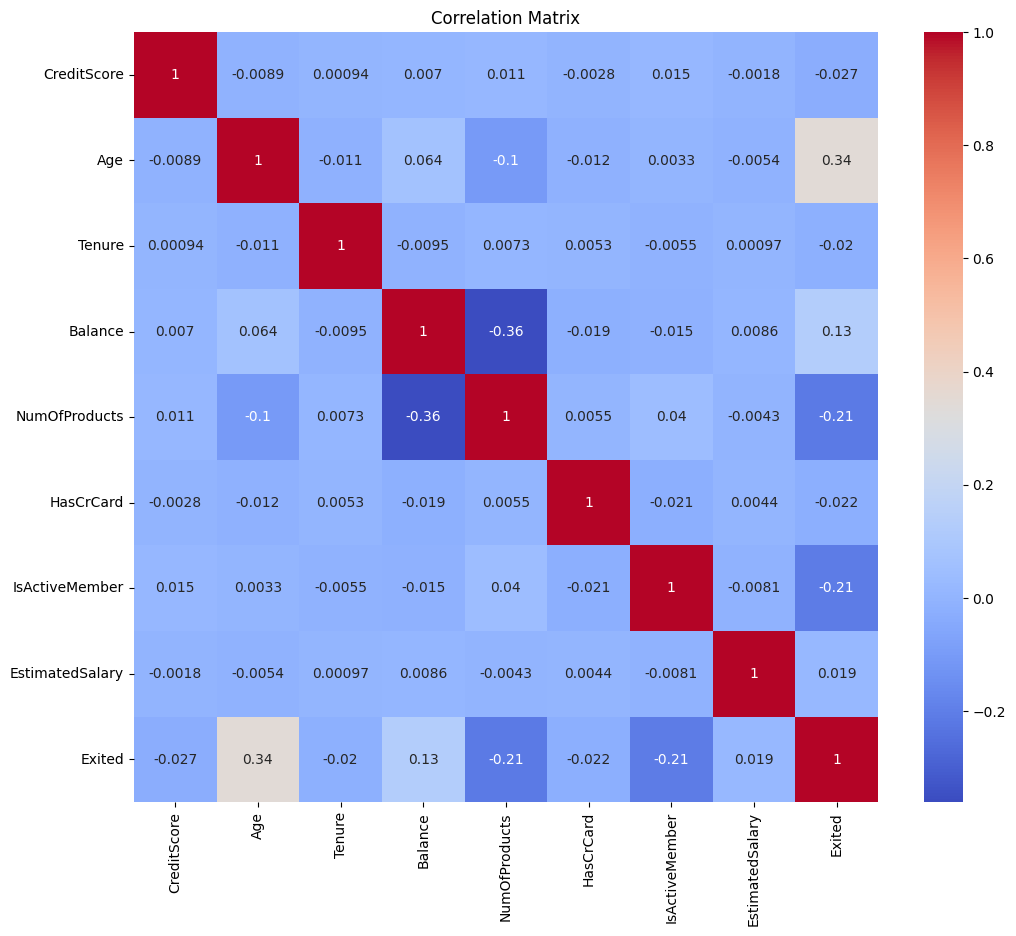

In [10]:
X_temp = X.copy()
X_temp['Exited'] = y

numeric_cols = X_temp.select_dtypes(include=['number']).columns

corr_matrix = X_temp[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [12]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])


In [13]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier(random_state=42))
])


In [14]:
param_grid_logreg = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
}

grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)


Best parameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}


In [15]:
param_grid_ridge = {
    'classifier__alpha': [0.01, 0.1, 1, 10],
}

grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_ridge.fit(X_train, y_train)

print("Best parameters for Ridge Classifier:", grid_search_ridge.best_params_)


Best parameters for Ridge Classifier: {'classifier__alpha': 10}


In [16]:
y_valid_pred_proba_logreg = grid_search_logreg.predict_proba(X_valid)[:, 1]

roc_auc_logreg = roc_auc_score(y_valid, y_valid_pred_proba_logreg)
print(f'Validation ROC-AUC Score for Logistic Regression: {roc_auc_logreg:.4f}')


Validation ROC-AUC Score for Logistic Regression: 0.8146


In [17]:
y_valid_decision_ridge = grid_search_ridge.decision_function(X_valid)

roc_auc_ridge = roc_auc_score(y_valid, y_valid_decision_ridge)
print(f'Validation ROC-AUC Score for Ridge Classifier: {roc_auc_ridge:.4f}')


Validation ROC-AUC Score for Ridge Classifier: 0.8149


In [18]:
cv_scores_logreg = cross_val_score(grid_search_logreg.best_estimator_, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f'Cross-Validation ROC-AUC Scores for Logistic Regression: {cv_scores_logreg}')
print(f'Mean ROC-AUC Score: {cv_scores_logreg.mean():.4f}')

cv_scores_ridge = cross_val_score(grid_search_ridge.best_estimator_, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f'Cross-Validation ROC-AUC Scores for Ridge Classifier: {cv_scores_ridge}')
print(f'Mean ROC-AUC Score: {cv_scores_ridge.mean():.4f}')


Cross-Validation ROC-AUC Scores for Logistic Regression: [0.82114161 0.81753826 0.81786104 0.81861281 0.81413404]
Mean ROC-AUC Score: 0.8179
Cross-Validation ROC-AUC Scores for Ridge Classifier: [0.82170304 0.81772619 0.81751637 0.81885229 0.81408951]
Mean ROC-AUC Score: 0.8180


In [19]:
best_logreg_model = grid_search_logreg.best_estimator_
best_logreg_model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [20]:
y_test_pred_proba = best_logreg_model.predict_proba(X_test)[:, 1]


In [21]:
if np.array_equal(test['id'].values, sample_submission['id'].values):
    print("IDs match between test set and sample submission.")
    sample_submission['Exited'] = y_test_pred_proba
else:
    print("IDs do not match. Merging on 'id'.")
    predictions = pd.DataFrame({
        'id': test['id'],
        'Exited': y_test_pred_proba
    })
    sample_submission = sample_submission[['id']].merge(predictions, on='id', how='left')

sample_submission.to_csv('submission2.csv', index=False)


IDs match between test set and sample submission.


In [22]:
if np.array_equal(test['id'].values, sample_submission['id'].values):
    print("IDs match between test set and sample submission.")
    sample_submission['Exited'] = y_test_pred_proba
else:
    print("IDs do not match. Merging on 'id'.")
    predictions = pd.DataFrame({
        'id': test['id'],
        'Exited': y_test_pred_proba
    })
    sample_submission = sample_submission[['id']].merge(predictions, on='id', how='left')

sample_submission.to_csv('submission2.csv', index=False)
if np.array_equal(test['id'].values, sample_submission['id'].values):
    print("IDs match between test set and sample submission.")
    sample_submission['Exited'] = y_test_pred_proba
else:
    print("IDs do not match. Merging on 'id'.")
    predictions = pd.DataFrame({
        'id': test['id'],
        'Exited': y_test_pred_proba
    })
    sample_submission = sample_submission[['id']].merge(predictions, on='id', how='left')

sample_submission.to_csv('submission2.csv', index=False)


IDs match between test set and sample submission.
IDs match between test set and sample submission.


In [23]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42))
])

param_grid_logreg = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
}

grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember',
                                                                          'EstimatedSalary']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Geography',
                                                                          'Gender'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc')

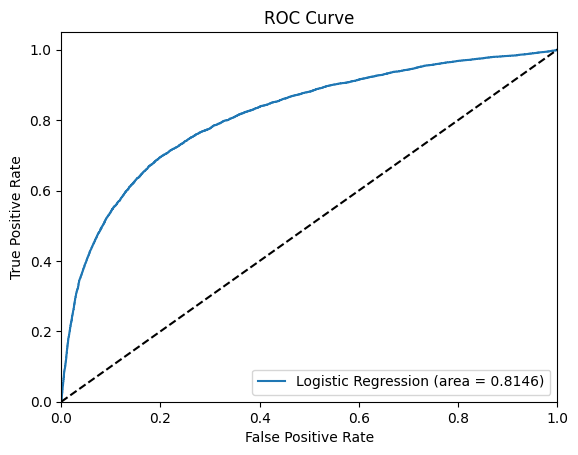

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_proba_logreg)

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {roc_auc_logreg:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
